# Convergence at the leaves

## 1 Setup

Setup the database

In [1]:
from utils import setup_spreadr
setup_spreadr('spreadr_exp_1')

Imports for the analysis

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
from pandas import DataFrame, concat
from scipy.stats import linregress
import seaborn as sb

from gists.models import Sentence, Tree

from utils import grouper, memoized, mpl_palette

Equip models with useful tools

In [3]:
from utils import equip_spreadr_models as utils_equip
utils_equip()

from linguistics import equip_spreadr_models as linguistics_equip
linguistics_equip()

## 2 Convergence at the leaves

### 2.1 leaf variability ~ root length

First define leaf variability for a tree

In [4]:
def variability(array, measure):
    length = len(array)
    measures = np.zeros((length - 1) * length / 2)
    k = 0
    for i, a in enumerate(array):
        for b in array[:i]:
            measures[k] = measure(a, b)
            k += 1
    return measures

@memoized
def get_leaf_variability_detailed(self):
    leaves = [s for s in self.sentences.ham.all() if s.children.ham.count() == 0]
    return variability(leaves, lambda l1, l2: l1.ordered_content_distance(l2))

@memoized
def get_leaf_variability(self):
    return self.leaf_variability_detailed.mean()

Tree.leaf_variability_detailed = property(get_leaf_variability_detailed)
Tree.leaf_variability = property(get_leaf_variability)

Then generate our data

In [5]:
trees = Tree.objects.experiment.all()
data_trees = []
for tree in trees:
    lvd = tree.leaf_variability_detailed
    data_trees.append(DataFrame({'tree id': [tree.id] * len(lvd),
                                 'root length': [len(tree.root.content_words)] * len(lvd),
                                 'leaf couple separation': lvd}))
data = concat(data_trees)
data_m15 = data[data['root length'] < 15]
root_order = data.groupby('tree id', as_index=False).mean().sort_values(\
    ['root length', 'tree id'])
root_order_m15 = data_m15.groupby('tree id', as_index=False).mean().sort_values(\
    ['root length', 'tree id'])

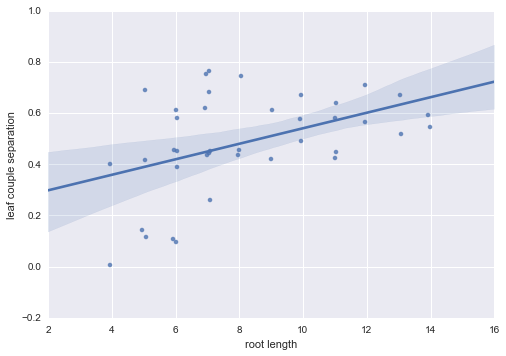

In [6]:
sb.regplot(data_m15.groupby('tree id').mean()['root length'],
           data_m15.groupby('tree id').mean()['leaf couple separation'],
           x_jitter=.1, y_jitter=.01);

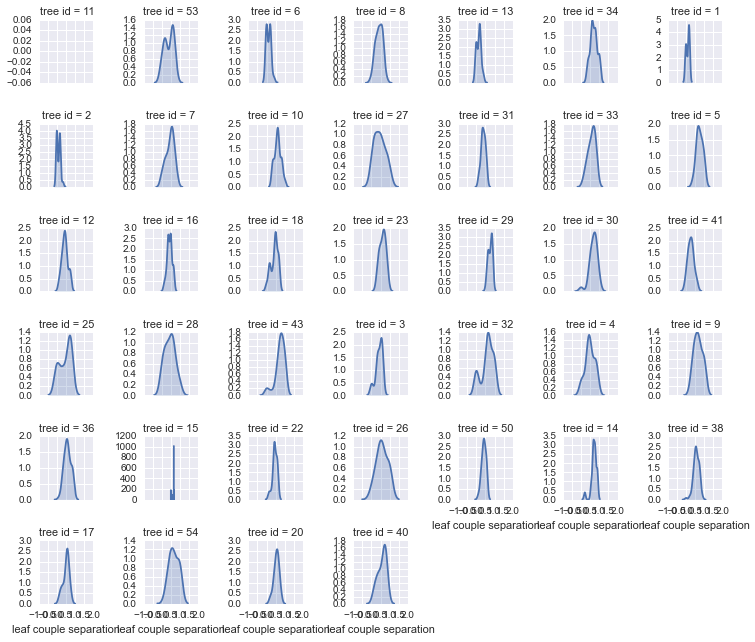

In [7]:
g = sb.FacetGrid(data=data_m15, sharey=False,
                 col='tree id', col_wrap=7, size=1.5,
                 col_order=root_order_m15['tree id'])
g.map(sb.kdeplot, 'leaf couple separation', shade=True);

### 2.2 leaf variability ~ branch variability

In [8]:
@memoized
def get_branches(self):
    # TBD

@memoized
def get_branches_variability(self):
    # TBD
    # get branches
    # get variability for each branch
    # mean

IndentationError: expected an indented block (<ipython-input-8-8c34326e496f>, line 5)